In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Warp simulations of space-charge neutralized electron beam

In [2]:
%matplotlib notebook

In [3]:
import sys
import numpy as np
import h5py as h5
import pickle

from rswarp.utilities import beam_analysis
from rswarp.utilities import file_utils
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import linregress
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/interpolate/_bs

In [5]:
from scipy.constants import c, physical_constants, m_e, e
m_e_ev = physical_constants['electron mass energy equivalent in MeV'][0]
m_e_kg = m_e

In [6]:
from cycler import cycler
colors = ["xkcd:windows blue", "xkcd:amber", "xkcd:faded green", 
          "xkcd:dusty purple", "xkcd:blood orange", "xkcd:bluish grey", 
          "xkcd:carmine", "xkcd:greenish blue", "xkcd:wine",
          "xkcd:spruce"]

# Functions
Useful functions for this notebook

In [7]:
# energy calculations
def p_to_beta(p, m=m_e_ev):
    # Assumes p in MeV/c
    p = p / (m * c)
    return p / np.sqrt(1 + p**2)
def p_to_ke(p, m=m_e_ev):
    # assumes p in MeV/c
    # returns KE in MeV
    beta = p_to_beta(p)
    gamma = 1 / np.sqrt(1 - beta**2)
    return m * gamma - m

# plotting routines
def map_colorbar(n, *args):
    n = len(full.keys())
    color = plt.cm.viridis_r(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
    hexcolor = map(lambda rgb:'#%02x%02x%02x' % (rgb[0]*255,rgb[1]*255,rgb[2]*255),
               tuple(color[:,0:-1]))
    
    for axis in args:
        axis.set_prop_cycle('color', hexcolor)

def create_colorbar(vmin, vmax, axis, bbox_to_anchor=(1.01, 0.25, 1, 1)):
    axins = inset_axes(axis,
                       width="5%",  # width = 10% of parent_bbox width
                       height="50%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=axis.transAxes,
                       borderpad=0,
                       )
    axins.text(01.25, 1.05,'Time Step', horizontalalignment='center', 
               verticalalignment='center',
               transform=axins.transAxes)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb1 = mpl.colorbar.ColorbarBase(axins, cmap=plt.cm.viridis_r,
                                    norm=norm,
                                    orientation='vertical')

# Data Import
Import data from Warp simulation for analysis

In [8]:
path = 'diags/hdf5/'
full =  file_utils.loadparticlefiles(path)

In [9]:
step_min = min(full.keys())
step_max = max(full.keys())

# Assume uniform spacing
step_interval = step_max  / len(full.keys())

In [10]:
# Grab simulation attributes we'll need (why 500?)
ff = h5.File('diags/hdf5/data00000500.h5', 'r')
beam_sw = np.average(ff['data/500/particles/Electron/weighting'])  # Macroparticle weight of beam
ion_sw = np.average(ff['data/500/particles/H2+/weighting'])  # Macroparticle weight of ions
timestep = ff['data/500'].attrs['dt']
ff.close()

## Population Calculations

### Background H2 Gas

In [11]:
P = 0.4  # Pa
T = 273.0  # K

pipe_radius = 0.1524 / 2.
pipe_length = 2.0

V = np.pi * pipe_radius**2 * pipe_length
R = 8.314
n = P / (R * T)  # in moles / m**3
n_h2 = n * 6.022e23 * (1e-2)**3  # atoms / cm**3

print("For a pressure of {} Pa the density of H2 is {} atoms/cm^3".format(P, n_h2))

For a pressure of 0.4 Pa the density of H2 is 1.06127534562e+14 atoms/cm^3


### Electron Beam

In [12]:
# electron density
electron_current = 10e-3  # A
electron_beam_radius = 1.  # cm
electron_beam_length = 200  # cm
electron_beam_velocity = 0.990813945176 * c * 1e2  # beam velocity in cm/s

n_e = electron_current / e / (electron_beam_velocity) / (np.pi * electron_beam_radius**2) # electrons / cm**3
print("Electron beam density: {} atoms / cm^3".format(n_e))

Electron beam density: 668847.216145 atoms / cm^3


### Ions

In [13]:
h2_weight_kg = 3.3444946e-27
h2_weight_ev = 1876.124

<IPython.core.display.Javascript object>


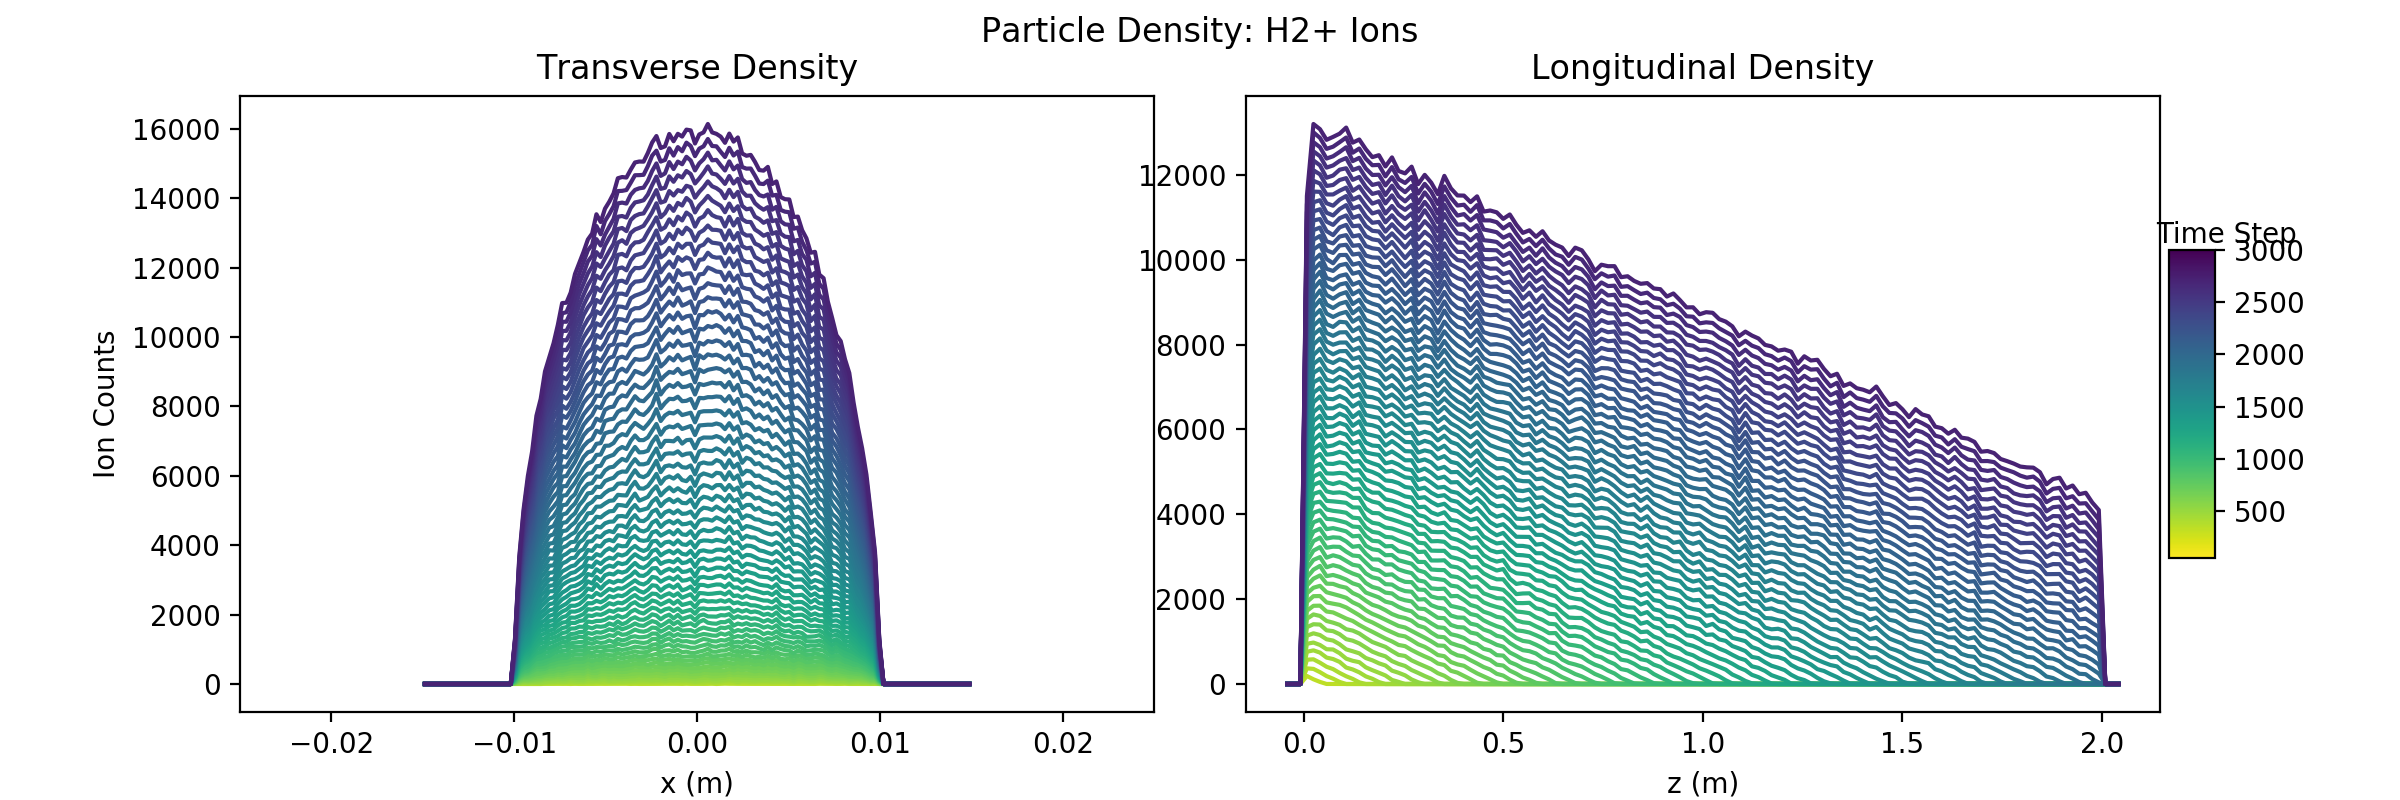

In [14]:
ion_profile, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
# exlicitly make ion_profile the active figure:
plt.figure(ion_profile.number)

plt.suptitle('Particle Density: H2+ Ions')

n = len(full.keys())
map_colorbar(n, ax1, ax2)

ax1.set_title("Transverse Density")
ax2.set_title("Longitudinal Density")

neutralization_efficiency = []
for step in sorted(full.keys()):
    counts, edges = np.histogram(full[step]['H2+'][:, 4], 128, range=(-0.05, 2.05))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts, label='{}'.format(step))
    counts, edges = np.histogram(full[step]['H2+'][:, 0], 128, range=(-0.015, 0.015))
    neutralization_efficiency.append(-counts[64])
    
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    test = ax1.plot(centers, counts, label='{}'.format(step))
    
final_ion_density = counts

ax1.set_xlabel('x (m)')
ax1.set_ylabel('Ion Counts')
ax2.set_xlabel('z (m)')
ax1.set_xlim(-0.025, 0.025)

# Make colorbar
create_colorbar(min(full.keys()), max(full.keys()), ax2)

# clean up plot positions
plt.subplots_adjust(left=0.1, wspace=0.1)

# ion_profile.savefig('profile_ions.pdf')
plt.show()

### Background Electrons

<IPython.core.display.Javascript object>


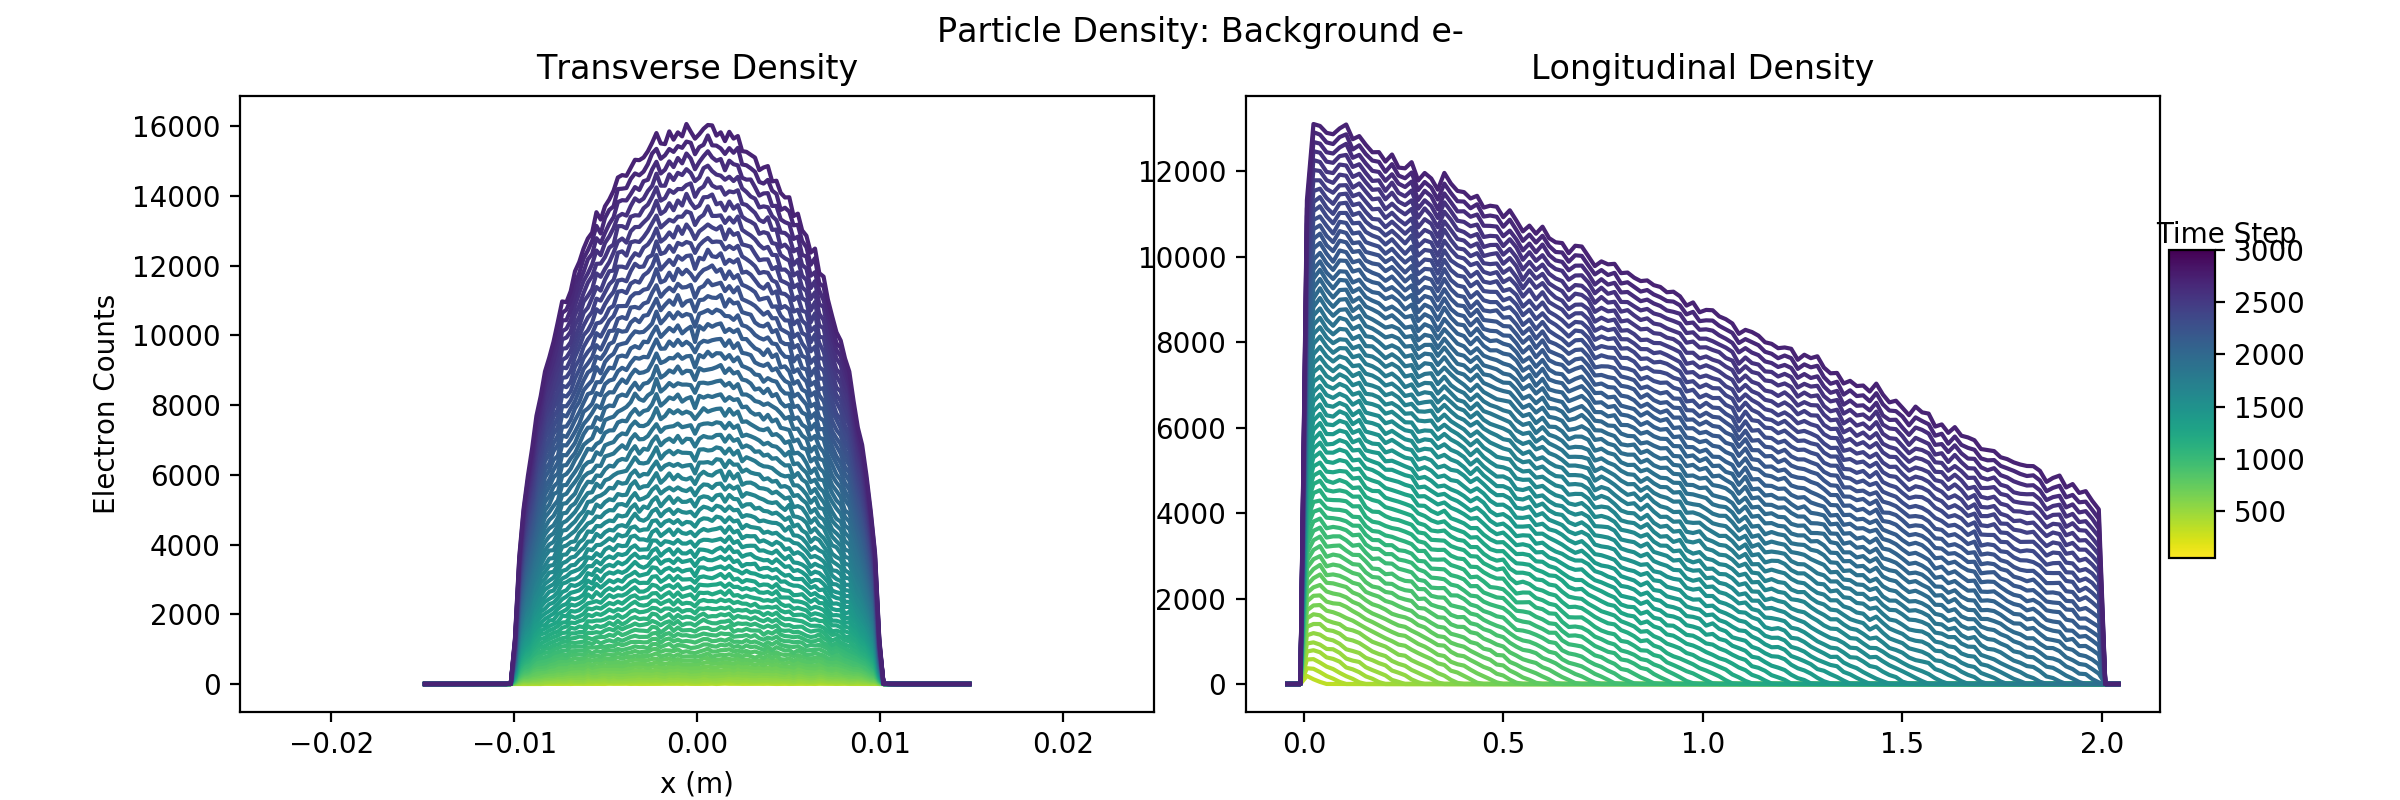

In [15]:
electron_profile, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
# exlicitly make electron_profile the active figure:
plt.figure(electron_profile.number)
# ax1.set_prop_cycle(cycler('color', colors))

n = len(full.keys())
map_colorbar(n, ax1, ax2)

plt.suptitle('Particle Density: Background e-')

ax1.set_title("Transverse Density")
ax2.set_title("Longitudinal Density")

time_slice = 0
for step in sorted(full.keys()):
    counts, edges = np.histogram(full[step]['emitted e-'][:, 4], 128, range=(-0.05, 2.05))
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts, label='{}'.format(step))

    counts, edges = np.histogram(full[step]['emitted e-'][:, 0], 128, range=(-0.015, 0.015))
    #neutralization_efficiency[time_slice] -= counts[64]; time_slice += 1
    neutralization_efficiency[time_slice] += counts[64]; time_slice += 1
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax1.plot(centers, counts, label='{}'.format(step))
    
final_emitted_electron_density = counts

ax1.set_xlabel('x (m)')
ax1.set_ylabel('Electron Counts')

# Make colorbar
create_colorbar(min(full.keys()), max(full.keys()), ax2)

ax1.set_xlim(-0.025, 0.025)

# clean up plot positions
plt.subplots_adjust(left=0.1, wspace=0.1)

# electron_profile.savefig('profile_electrons.pdf')
plt.show()

### Analyzing Electron Beam

In [16]:
beam_profile, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))
# exlicitly make beam_profile the active figure:
plt.figure(beam_profile.number)
n = len(full.keys())
map_colorbar(n, ax1, ax2)

plt.suptitle('Particle Density: e- Beam')

ax1.set_title("Transverse Density")
ax2.set_title("Longitudinal Density")

time_slice = 0
for step in sorted(full.keys()):
    counts, edges = np.histogram(full[step]['Electron'][:, 4], 128, range=(-0.05, 2.05))
    dz = 2.1 / len(counts)
    current = 215. * dz * 1e4 / electron_beam_velocity
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax2.plot(centers, counts * current, label='{}'.format(step))

    counts, edges = np.histogram(full[step]['Electron'][:, 0], 128, range=(-0.015, 0.015))
    #neutralization_efficiency[time_slice] = 1. - (counts[64] - neutralization_efficiency[time_slice]) / counts[64]; time_slice += 1
    neutralization_efficiency[time_slice] += counts[64]; time_slice += 1
    centers = []
    for i in range(edges.size - 1):
        centers.append((edges[i + 1] + edges[i]) / 2.)
    ax1.plot(centers, counts, label='{}'.format(step))
    
final_beam_electron_density = counts

ax1.set_xlabel('x (m)')
ax1.set_ylabel('Electron Counts')

ax2.set_xlabel('z (m)')
ax1.set_ylabel('Current (A)')

# Make colorbar
create_colorbar(min(full.keys()), max(full.keys()), ax2)

ax1.set_xlim(-0.025, 0.025)

#beam_profile.savefig('profile_beam.pdf')

plt.show()

<IPython.core.display.Javascript object>

# Final density profiles

In [17]:
finaldens, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(centers, final_beam_electron_density, label='beam electron density')
ax1.plot(centers, final_emitted_electron_density, label='emitted electron density')
ax1.plot(centers, final_ion_density, label='emitted ion density')
ax1.plot(centers, final_beam_electron_density + final_emitted_electron_density - final_ion_density, label='effective reduced beam density')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('particle counts')
ax1.set_xlim(-0.025, 0.025)
ax1.grid(True)
ax1.legend()

ax2.plot(neutralization_efficiency)

plt.show()

<IPython.core.display.Javascript object>

# Fields
Ion populations are far too low to observe changes in fields but these should be useful eventually

In [18]:
step0 = 1000
step1 = 3000
field_file_0 = 'diags/fields/electric/data0{}.h5'.format(step0)
field_file = 'diags/fields/electric/data0{}.h5'.format(step1)
fields_0 = h5.File(field_file_0, 'r')
fields = h5.File(field_file, 'r')

In [19]:
for key in fields['data/{}/meshes/E'.format(step1)].keys():
    print key

r
t
z


In [20]:
phi_0 = fields_0['data/{}/meshes/phi'.format(step0)]
efield_0 = fields_0['data/{}/meshes/E'.format(step0)]

phi_1 = fields['data/{}/meshes/phi'.format(step1)]
efield_1 = fields['data/{}/meshes/E'.format(step1)]

### Potential on x vs z

In [21]:
potential1, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.imshow(phi_0[0,:,:], aspect=10)
plt.colorbar(a1)

plt.show()

<IPython.core.display.Javascript object>

### Potential vs z at x=xmax//2

In [22]:
potential2, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.plot(phi_0[0,56,:])
a2 = ax1.plot(phi_1[0,56,:])

plt.show()

<IPython.core.display.Javascript object>

### Radial component of electric field 

In [23]:
efield, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.imshow(efield_1['r'][0,:,:], aspect=10)
plt.colorbar(a1)

plt.show()

<IPython.core.display.Javascript object>

### Potential vs r at z=zmax//2

In [24]:
potential_profile, ax1 = plt.subplots(1, 1, figsize=(4, 4))

a1 = ax1.plot(phi_0[0,:,512], label='Step: {}'.format(step0))
a2 = ax1.plot(phi_1[0,:,512], label='Step: {}'.format(step1))

plt.legend()
plt.show()

<IPython.core.display.Javascript object>